# IMPORTS

In [21]:
# Clone the Git repository and navigate to the project directory
!git clone https://github.com/DanteMillerDS/MPA_Predictor.git
%cd MPA_Predictor

# Install required packages
!pip install xgboost
!pip install pytorch-tabnet
!pip install torch

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import torch
import uuid
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
import torch
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
from pytorch_tabnet.tab_model import TabNetRegressor
import keras

# Set random seeds for reproducibility
np.random.seed(1000)
tf.random.set_seed(1000)

Cloning into 'MPA_Predictor'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 35 (delta 8), reused 21 (delta 4), pack-reused 0
Receiving objects: 100% (35/35), 4.92 MiB | 7.38 MiB/s, done.
Resolving deltas: 100% (8/8), done.
/content/MPA_Predictor/MPA_Predictor


# PREPROCESSING

In [22]:
file_paths = dict()
file_paths[0] = ["data/s11_dB_freq.txt"]

def process_file(file_path):
    datasets = []
    with open(file_path, 'r') as file:
        current_dataset = []
        for line in file:
            if line.startswith("#Parameters"):
                if current_dataset:
                    datasets.append(current_dataset)
                    current_dataset = []
                params_str = line[line.index("{") + 1:line.index("}")]
                params = dict(param.split('=') for param in params_str.split(';'))
                current_dataset.append(params)
            elif line.startswith("#"):
                continue
            else:
                data = line.strip().split('\t')
                current_dataset.append(data)
        if current_dataset:
            datasets.append(current_dataset)
    data = []
    for dataset in datasets:
        permittivity_values = dataset[0]
        df_data = dataset[1:]
        s_parameter_name = file_path.split("_parameter_data_for_")[0]
        df = pd.DataFrame(df_data, columns=["Frequency", f"{s_parameter_name}"])
        df["ID"] = str(uuid.uuid4())[:8]
        for key, value in permittivity_values.items():
            df[key.replace(" ", "")] = value
        data.append(df)
    return data
all_combined_data = []
for index in file_paths:
    for file in file_paths[index]:
        combined_data = process_file(file)
        combined_data = pd.concat(combined_data, ignore_index=True)
        all_combined_data.append(combined_data)
array = []
group_size = 4
for i in range(0, len(all_combined_data), group_size):
    combined_dataframe = pd.concat(all_combined_data[i:i+group_size], axis=1)
    combined_dataframe.reset_index(drop=True, inplace=True)
    array.append(combined_dataframe)
training_dataframe = pd.concat(array, axis=0)
training_dataframe.reset_index(drop=True, inplace=True)
training_dataframe = training_dataframe.loc[:, ~training_dataframe.columns.duplicated()]

In [23]:
print(training_dataframe.columns)

Index(['Frequency', 'data/s11_dB_freq.txt', 'ID', 'rprobe', 'rin', 'er22',
       'er2', 'cl', 'r0', 'w', 'L', 't', 'h', 'wy', 'wx', 'er11', 'er1'],
      dtype='object')


In [24]:
needed_columns = ["Frequency","data/s11_dB_freq.txt","h","t","er11","er1","w","L"]
training_dataframe = training_dataframe[needed_columns]

In [25]:
training_dataframe.columns = ["Frequency","Input_Impedance","Substrate_Thickness","Patch_Thickness","Permittivity_Imaginary","Permittivity_Real","Width","Length"]

In [26]:
training_dataframe.columns

Index(['Frequency', 'Input_Impedance', 'Substrate_Thickness',
       'Patch_Thickness', 'Permittivity_Imaginary', 'Permittivity_Real',
       'Width', 'Length'],
      dtype='object')

In [27]:
training_dataframe.dropna(inplace=True)
columns = training_dataframe.columns[1:]
training_dataframe[columns] = training_dataframe[columns].apply(pd.to_numeric)

In [28]:
training_dataframe.describe()

,Input_Impedance,Substrate_Thickness,Patch_Thickness,Permittivity_Imaginary,Permittivity_Real,Width,Length
count,100100.000000,1.001000e+05,1.001000e+05,1.001000e+05,1.001000e+05,100100.000000,100100.000000
mean,-3.252633,1.600000e+00,2.000000e-01,1.000000e-02,2.550000e+00,28.759751,46.015602
std,4.162713,2.220457e-16,2.775571e-17,1.734732e-18,4.440914e-16,13.298825,21.278120
min,-29.213769,1.600000e+00,2.000000e-01,1.000000e-02,2.550000e+00,5.535593,8.856949
25%,-4.395586,1.600000e+00,2.000000e-01,1.000000e-02,2.550000e+00,16.560724,26.497158
50%,-1.654782,1.600000e+00,2.000000e-01,1.000000e-02,2.550000e+00,29.681131,47.489809
75%,-0.417934,1.600000e+00,2.000000e-01,1.000000e-02,2.550000e+00,40.209226,64.334762
max,0.140660,1.600000e+00,2.000000e-01,1.000000e-02,2.550000e+00,48.676675,77.882680


In [29]:
training_dataframe.head(5)

,Frequency,Input_Impedance,Substrate_Thickness,Patch_Thickness,Permittivity_Imaginary,Permittivity_Real,Width,Length
0,1.0000000000000,-0.163918,1.6,0.2,0.01,2.55,41.662566,66.660105
1,1.0089999437332,-0.131358,1.6,0.2,0.01,2.55,41.662566,66.660105
2,1.0180000066757,-0.068440,1.6,0.2,0.01,2.55,41.662566,66.660105
3,1.0269999504089,-0.013418,1.6,0.2,0.01,2.55,41.662566,66.660105
4,1.0360000133514,-0.000152,1.6,0.2,0.01,2.55,41.662566,66.660105


In [30]:
lowest_impedance_rows = pd.DataFrame(columns=training_dataframe.columns)
for i in range(0,len(training_dataframe),1001):
  subset = training_dataframe[i:i+1001]
  min_impedance_row = subset[subset['Input_Impedance'] == subset['Input_Impedance'].min()]
  lowest_impedance_rows = pd.concat([lowest_impedance_rows, min_impedance_row])

In [31]:
lowest_impedance_rows

,Frequency,Input_Impedance,Substrate_Thickness,Patch_Thickness,Permittivity_Imaginary,Permittivity_Real,Width,Length
385,4.4650001525879,-20.224921,1.6,0.2,0.01,2.55,41.662566,66.660105
1344,4.0869998931885,-19.536557,1.6,0.2,0.01,2.55,45.760637,73.217019
2983,9.8290004730225,-24.501126,1.6,0.2,0.01,2.55,10.714407,17.143051
3343,4.0599999427795,-19.490123,1.6,0.2,0.01,2.55,46.101914,73.763062
4503,5.4910001754761,-23.453824,1.6,0.2,0.01,2.55,33.456166,53.529866
...,...,...,...,...,...,...,...,...
96065,9.7299995422363,-25.363050,1.6,0.2,0.01,2.55,10.845779,17.353247
96647,5.9590001106262,-25.414828,1.6,0.2,0.01,2.55,30.597065,48.955304
97751,6.8860001564026,-27.873510,1.6,0.2,0.01,2.55,26.122579,41.796126
98961,8.7670001983643,-17.926713,1.6,0.2,0.01,2.55,5.535593,8.856949


In [32]:
training_dataframe = lowest_impedance_rows

# DATA VISUALIZATION

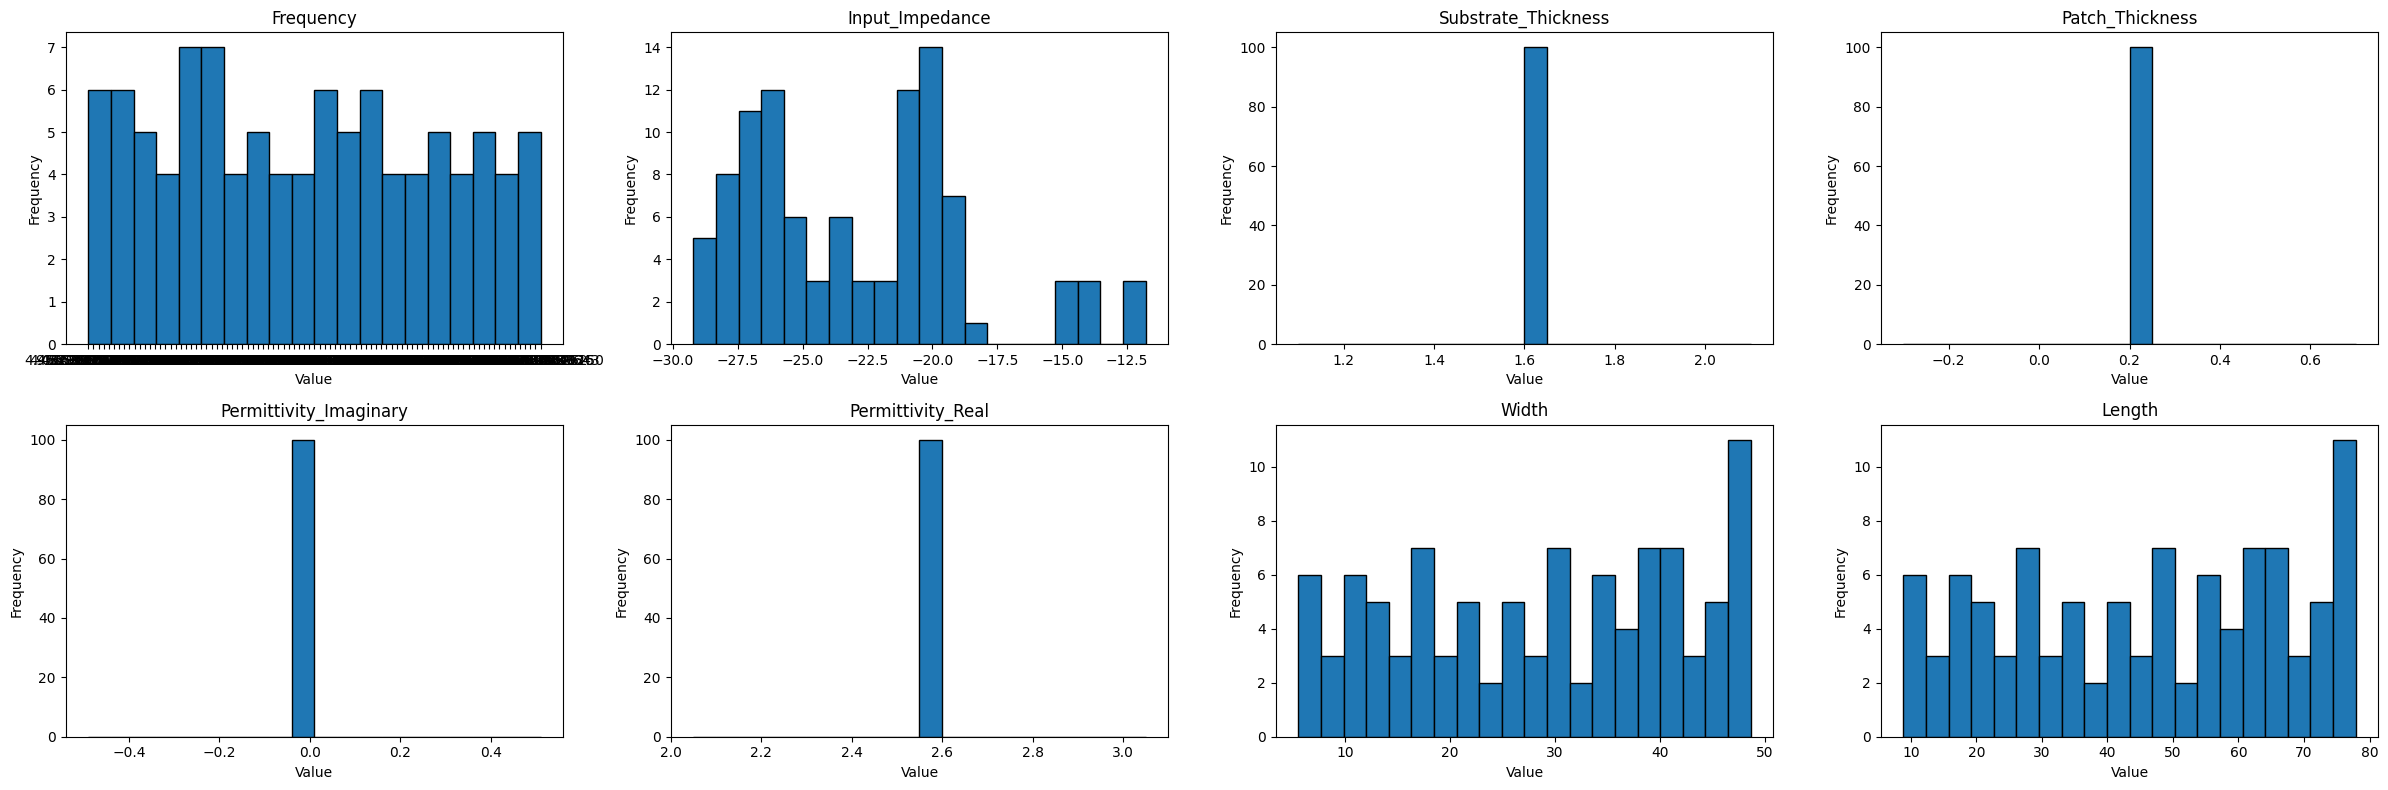

In [33]:
plt.figure(figsize=(24, 8))
for i, column in enumerate(training_dataframe.columns):
    plt.subplot(2,4 , i+1)
    plt.hist(training_dataframe[column], bins=20, edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [34]:
columns = ["Input_Impedance","Width","Length"]
training_mean_predicted_values = training_dataframe.groupby('Frequency')[columns].mean()

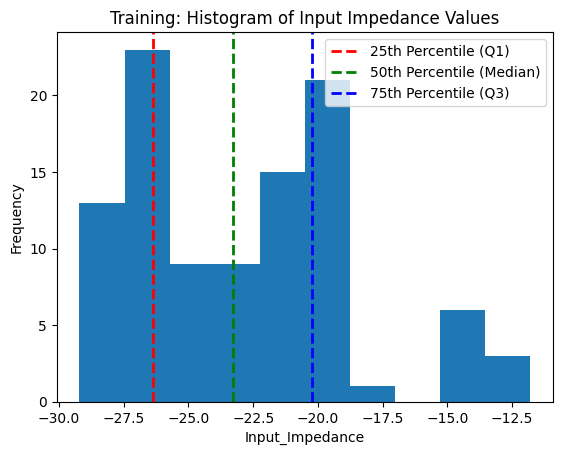

In [35]:
q25 = np.percentile(training_dataframe["Input_Impedance"], 25)
q50 = np.percentile(training_dataframe["Input_Impedance"], 50)
q75 = np.percentile(training_dataframe["Input_Impedance"], 75)
plt.hist(training_dataframe["Input_Impedance"])
plt.xlabel("Input_Impedance")
plt.ylabel("Frequency")
plt.title("Training: Histogram of Input Impedance Values")
plt.axvline(q25, color='red', linestyle='dashed', linewidth=2, label='25th Percentile (Q1)')
plt.axvline(q50, color='green', linestyle='dashed', linewidth=2, label='50th Percentile (Median)')
plt.axvline(q75, color='blue', linestyle='dashed', linewidth=2, label='75th Percentile (Q3)')
plt.legend()
plt.show()

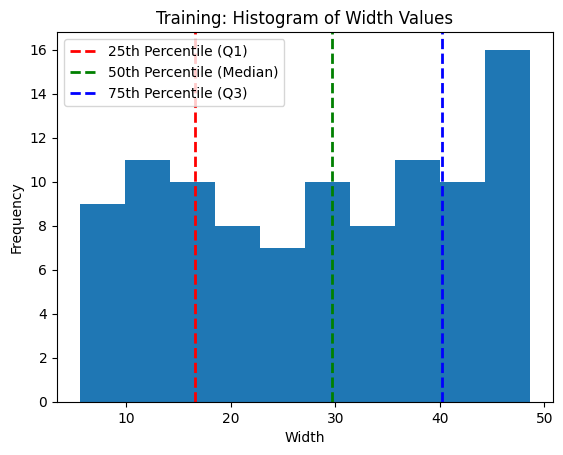

In [36]:
q25 = np.percentile(training_dataframe["Width"], 25)
q50 = np.percentile(training_dataframe["Width"], 50)
q75 = np.percentile(training_dataframe["Width"], 75)
plt.hist(training_dataframe["Width"])
plt.xlabel("Width")
plt.ylabel("Frequency")
plt.title("Training: Histogram of Width Values")
plt.axvline(q25, color='red', linestyle='dashed', linewidth=2, label='25th Percentile (Q1)')
plt.axvline(q50, color='green', linestyle='dashed', linewidth=2, label='50th Percentile (Median)')
plt.axvline(q75, color='blue', linestyle='dashed', linewidth=2, label='75th Percentile (Q3)')
plt.legend()
plt.show()

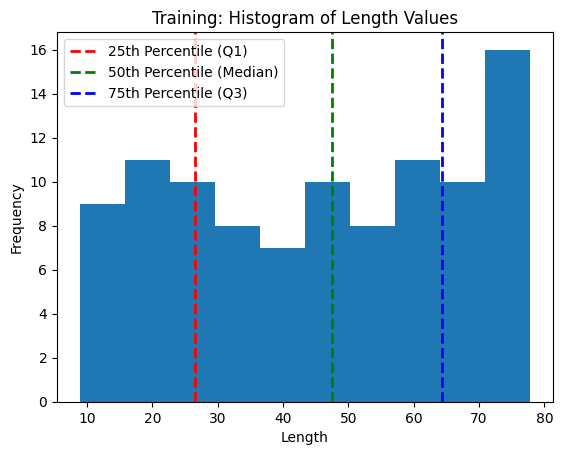

In [37]:
q25 = np.percentile(training_dataframe["Length"], 25)
q50 = np.percentile(training_dataframe["Length"], 50)
q75 = np.percentile(training_dataframe["Length"], 75)
plt.hist(training_dataframe["Length"])
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.title("Training: Histogram of Length Values")
plt.axvline(q25, color='red', linestyle='dashed', linewidth=2, label='25th Percentile (Q1)')
plt.axvline(q50, color='green', linestyle='dashed', linewidth=2, label='50th Percentile (Median)')
plt.axvline(q75, color='blue', linestyle='dashed', linewidth=2, label='75th Percentile (Q3)')
plt.legend()
plt.show()

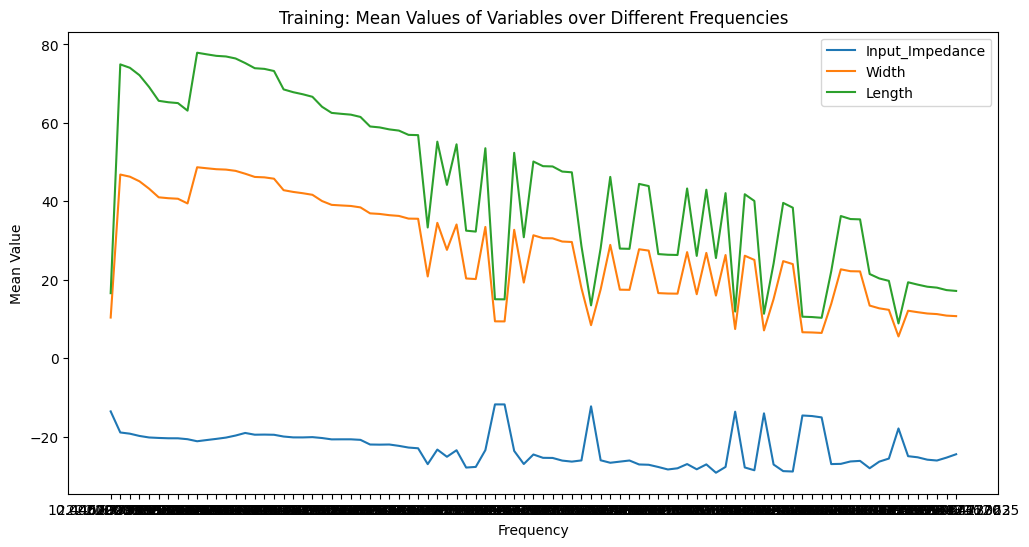

In [38]:
plt.figure(figsize=(12, 6))
for col in training_mean_predicted_values.columns:
    plt.plot(training_mean_predicted_values.index, training_mean_predicted_values[col], label=col)
plt.xlabel('Frequency')
plt.ylabel('Mean Value')
plt.title('Training: Mean Values of Variables over Different Frequencies')
plt.legend()
plt.show()

# DATA MANIPULATION

In [39]:
bc = PowerTransformer()
bc.fit(training_dataframe[["Input_Impedance","Width","Length"]])
training_dataframe[training_dataframe[["Input_Impedance","Width","Length"]].columns] = bc.transform(training_dataframe[["Input_Impedance","Width","Length"]])

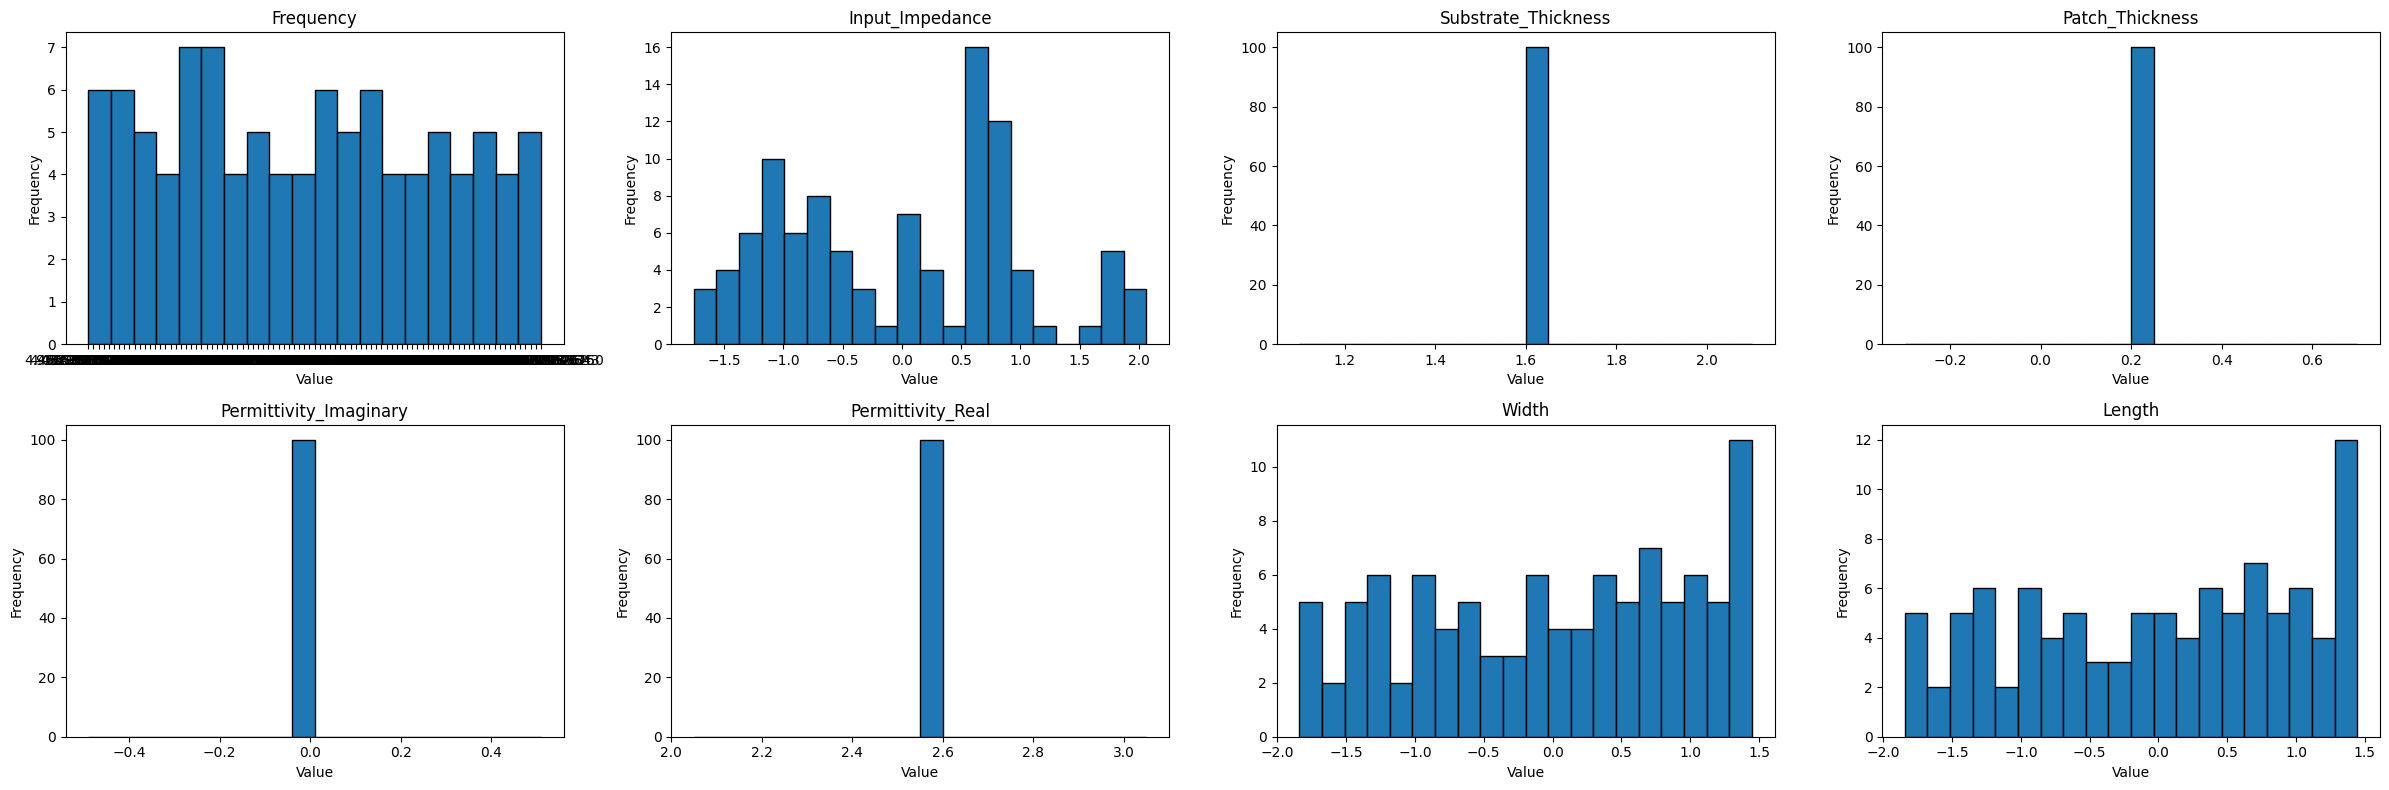

In [40]:
plt.figure(figsize=(24, 8))
for i, column in enumerate(training_dataframe.columns):
    plt.subplot(2,4 , i+1)
    plt.hist(training_dataframe[column], bins=20, edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# MODELS

In [41]:
LR = 0.001
L2 = 0.0001
WD = 0.00001

In [42]:
columns = []
for column in training_dataframe.columns:
    if column not in ["Width","Length","Input_Impedance"]:
        columns.append(column)
columns

['Frequency',
 'Substrate_Thickness',
 'Patch_Thickness',
 'Permittivity_Imaginary',
 'Permittivity_Real']

In [43]:
X_train = training_dataframe[columns].values
y_train = training_dataframe[["Width","Length","Input_Impedance"]].values
selected_indices = np.random.permutation(len(training_dataframe))
X_selected = X_train[selected_indices]
y_selected = y_train[selected_indices]
# grouped_indices = {}
# for idx in selected_indices:
#     row = training_dataframe.iloc[idx]
#     frequency = row['Frequency']
#     key = (frequency)
#     if key not in grouped_indices:
#         grouped_indices[key] = []
#     grouped_indices[key].append(idx)
X_train_indices = []
X_val_indices = []
X_test_indices = []
# for key, indices in grouped_indices.items():
train_indices, val_indices = train_test_split(selected_indices, test_size=0.2, random_state=42)
val_indices, test_indices = train_test_split(val_indices, test_size=0.5, random_state=42)
X_train_indices.extend(train_indices)
X_val_indices.extend(val_indices)
X_test_indices.extend(test_indices)
X_train = X_selected[X_train_indices]
y_train = y_selected[X_train_indices]
X_val = X_selected[X_val_indices]
y_val = y_selected[X_val_indices]
X_test = X_selected[X_test_indices]
y_test = y_selected[X_test_indices]
X_train = X_train.astype(float)
y_train = y_train.astype(float)
X_val = X_val.astype(float)
y_val = y_val.astype(float)
X_test = X_test.astype(float)
y_test = y_test.astype(float)

In [44]:
num_obs_train = len(X_train)
num_obs_val = len(X_val)
num_obs_test = len(X_test)
total_obs = num_obs_train + num_obs_val + num_obs_test
data = {'Dataset': ['Training', 'Validation', 'Test', 'Total'],
        'Number of Observations': [num_obs_train, num_obs_val, num_obs_test, total_obs]}
observations_table = pd.DataFrame(data)
print(observations_table)

      Dataset  Number of Observations
0    Training                      80
1  Validation                      10
2        Test                      10
3       Total                     100


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               768       
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 3)                 51        
                                                                 
Total params: 11683 (45.64 KB)
Trainable params: 11683 (45.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
3/3 [====

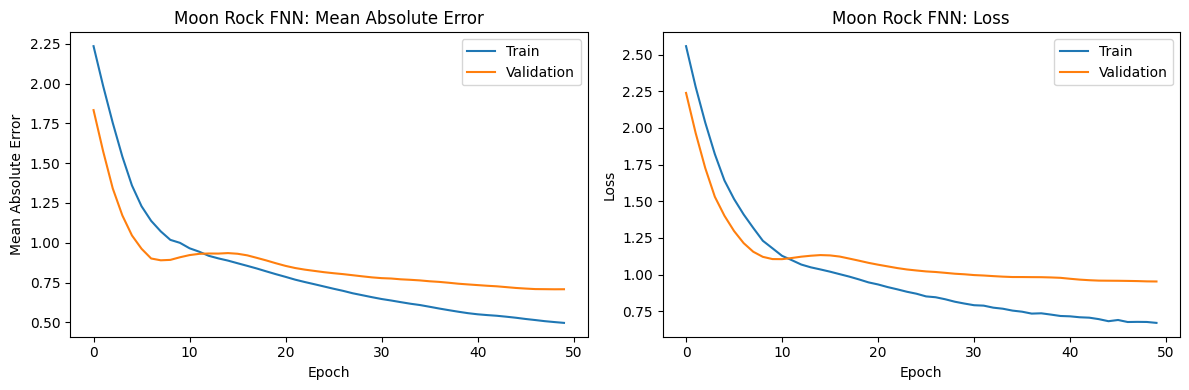

In [45]:
def rmse_loss(y_true, y_pred):
    squared_error = tf.square(y_true - y_pred)
    mean_squared_error = tf.reduce_mean(squared_error)
    root_mean_squared_error = tf.sqrt(mean_squared_error)
    return root_mean_squared_error

nn_model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],),kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(L2)),
    keras.layers.Dense(64, activation='relu', kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(L2)),
    keras.layers.Dense(32, activation='relu', kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(L2)),
    keras.layers.Dense(16, activation='relu', kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(L2)),
    keras.layers.Dense(y_train.shape[1], activation='linear')
])


nn_model.compile(optimizer=tf.optimizers.Adam(learning_rate=L2,weight_decay=WD),
              loss=[rmse_loss],
              metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])
nn_model.summary()
history = nn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=75,shuffle=True)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('FNN: Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(['Train', 'Validation'])
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('FNN: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()

In [46]:
xgb_model = xgb.XGBRegressor(n_jobs=-1,device="gpu",n_estimators=250,eval_metric=mean_absolute_error,verbosity=3,max_depth=6)
xgb_model.fit(X_train, y_train)

[02:10:05] ======== Monitor (0): HostSketchContainer ========
[02:10:05] AllReduce: 1.7e-05s, 1 calls @ 17us

[02:10:05] MakeCuts: 3.4e-05s, 1 calls @ 34us

[02:10:05] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [02:10:05] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[02:10:05] ======== Monitor (0): Learner ========
[02:10:05] Configure: 0.006486s, 1 calls @ 6486us

[02:10:05] EvalOneIter: 0.001161s, 250 calls @ 1161us

[02:10:05] GetGradient: 0.00164s, 250 calls @ 1640us

[02:10:05] PredictRaw: 0.002654s, 250 calls @ 2654us

[02:10:05] UpdateOneIter: 0.30304s, 250 calls @ 303040us

[02:10:05] ======== Monitor (0): GBTree ========
[02:10:05] BoostNewTrees: 0.281826s, 250 calls @ 281826us

[02:10:05] CommitModel: 0.000185s, 250 calls @ 185us

[02:10:05] ======== Monitor (0): HistUpdater ========
[02:10:05] BuildHistogram: 0.04645s, 1292 calls @ 46450us

[02:10:05] EvaluateSplits: 0.050194s, 2042 calls @ 50194us

[02:10:05] InitData: 0.027198s, 750 calls @ 27198us

[02:10:05] InitRoot: 0.053276s, 750 calls @ 53276us

[02:10:05] LeafPartition: 0.000228s, 750 calls @ 228us

[02:10:05] UpdatePosition: 0.054867s, 1615 calls @ 54867us

[02:10:05] UpdatePredictionCache: 0.004401s, 750 calls @ 4401us

[02:10:05] UpdateTree: 0.25405s, 750 calls @ 254050us



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False,
             eval_metric=<function mean_absolute_error at 0x78755a3c8280>,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=250,
             n_jobs=-1, num_parallel_tree=None, random_state=None, ...)

In [47]:
X_train_tensor = torch.tensor(X_train , dtype=torch.float32)
y_train_tensor = torch.tensor(y_train+y_train+y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
tabnet_model = TabNetRegressor(device_name = "cuda")
tabnet_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric=['rmse'],
    max_epochs=75,
)
# Plot the learning curves
# tabnet_model.plot_losses()

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_rmse: 1.14432 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_rmse: 1.14432 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_rmse: 1.14432 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_rmse: 1.14432 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_rmse: 1.14432 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_rmse: 1.14432 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_rmse: 1.14432 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_rmse: 1.14432 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_rmse: 1.14432 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_rmse: 1.14432 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_rmse: 1.14432 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_rmse = 1.14432


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


# EVALUATION

In [57]:
batch_size = 1
y_pred_nn = nn_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_tab = tabnet_model.predict(X_test)

# y_pred_nn = y_pred_nn.reshape(-1, batch_size, y_pred_nn.shape[-1])
# y_pred_xgb = y_pred_xgb.reshape(-1, batch_size, y_pred_xgb.shape[-1])
# y_pred_tab = y_pred_tab.reshape(-1, batch_size, y_pred_tab.shape[-1])

# y_pred_nn = np.mean(y_pred_nn, axis=1)
# y_pred_xgb = np.mean(y_pred_xgb, axis=1)
# y_pred_tab = np.mean(y_pred_tab, axis=1)

#y_test = np.mean(y_test, axis=1)

y_pred_0_nn, y_test_0 = y_pred_nn[:, 0], y_test[:, 0]
y_pred_1_nn, y_test_1 = y_pred_nn[:, 1], y_test[:, 1]
y_pred_2_nn, y_test_2 = y_pred_nn[:, 2], y_test[:, 2]

y_pred_0_xgb, _ = y_pred_xgb[:, 0], _
y_pred_1_xgb, _ = y_pred_xgb[:, 1], _
y_pred_2_xgb, _ = y_pred_xgb[:, 2], _
y_pred_0_tab, _ = y_pred_tab[:, 0], _
y_pred_1_tab, _ = y_pred_tab[:, 1], _
y_pred_2_tab, _ = y_pred_tab[:, 2], _

1/1 [==============================] - 1s 630ms/step


Metrics for XGBoost Model:
MSE: 0.3883
MAE: 0.2752
R-squared (R²): 0.6118

Metrics for FNN Model:
MSE: 0.2972
MAE: 0.4839
R-squared (R²): 0.7028

Metrics for TabNet Model:
MSE: 0.8352
MAE: 0.7334
R-squared (R²): 0.1648


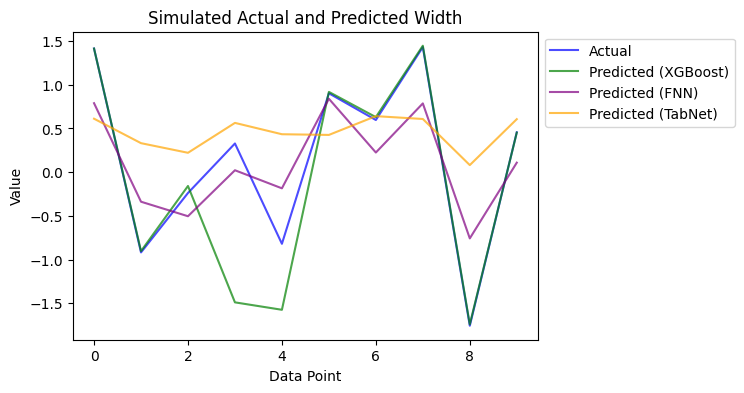

In [67]:
y_test_0 = np.mean(y_test_0.reshape(-1,batch_size),axis=1)
mse_xgb = mean_squared_error(y_test_0, y_pred_0_xgb)
mae_xgb = mean_absolute_error(y_test_0, y_pred_0_xgb)
r_squared_xgb = r2_score(y_test_0, y_pred_0_xgb)
mse_nn = mean_squared_error(y_test_0, y_pred_0_nn)
mae_nn = mean_absolute_error(y_test_0, y_pred_0_nn)
r_squared_nn = r2_score(y_test_0, y_pred_0_nn)
mse_tab = mean_squared_error(y_test_0, y_pred_0_tab)
mae_tab = mean_absolute_error(y_test_0, y_pred_0_tab)
r_squared_tab = r2_score(y_test_0, y_pred_0_tab)
print("Metrics for XGBoost Model:")
print(f"MSE: {mse_xgb:.4f}")
print(f"MAE: {mae_xgb:.4f}")
print(f"R-squared (R²): {r_squared_xgb:.4f}")
print("\nMetrics for FNN Model:")
print(f"MSE: {mse_nn:.4f}")
print(f"MAE: {mae_nn:.4f}")
print(f"R-squared (R²): {r_squared_nn:.4f}")
print("\nMetrics for TabNet Model:")
print(f"MSE: {mse_tab:.4f}")
print(f"MAE: {mae_tab:.4f}")
print(f"R-squared (R²): {r_squared_tab:.4f}")

colors = ['blue', 'green', 'purple', 'orange', 'red', 'cyan']

plt.figure(figsize=(6, 4))
plt.plot(range(len(y_test_0)), y_test_0, label='Actual', color=colors[0], alpha=0.7)
plt.plot(range(len(y_test_0)), y_pred_0_xgb, label='Predicted (XGBoost)', color=colors[1], alpha=0.7)
plt.plot(range(len(y_test_0)), y_pred_0_nn, label='Predicted (FNN)', color=colors[2], alpha=0.7)
plt.plot(range(len(y_test_0)), y_pred_0_tab, label='Predicted (TabNet)', color=colors[3], alpha=0.7)

plt.title('Simulated Actual and Predicted Width')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Metrics for XGBoost Model:
MSE: 0.3893
MAE: 0.2753
R-squared (R²): 0.6107

Metrics for FNN Model:
MSE: 0.2185
MAE: 0.4420
R-squared (R²): 0.7815

Metrics for TabNet Model:
MSE: 0.8975
MAE: 0.8217
R-squared (R²): 0.1025


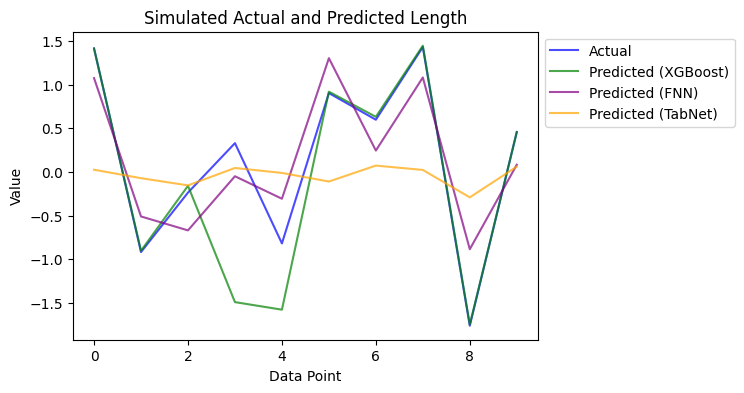

In [68]:
y_test_1 = np.mean(y_test_1.reshape(-1, batch_size), axis=1)
mse_xgb = mean_squared_error(y_test_1, y_pred_1_xgb)
mae_xgb = mean_absolute_error(y_test_1, y_pred_1_xgb)
r_squared_xgb = r2_score(y_test_1, y_pred_1_xgb)
mse_nn = mean_squared_error(y_test_1, y_pred_1_nn)
mae_nn = mean_absolute_error(y_test_1, y_pred_1_nn)
r_squared_nn = r2_score(y_test_1, y_pred_1_nn)
mse_tab = mean_squared_error(y_test_1, y_pred_1_tab)
mae_tab = mean_absolute_error(y_test_1, y_pred_1_tab)
r_squared_tab = r2_score(y_test_1, y_pred_1_tab)
print("Metrics for XGBoost Model:")
print(f"MSE: {mse_xgb:.4f}")
print(f"MAE: {mae_xgb:.4f}")
print(f"R-squared (R²): {r_squared_xgb:.4f}")
print("\nMetrics for FNN Model:")
print(f"MSE: {mse_nn:.4f}")
print(f"MAE: {mae_nn:.4f}")
print(f"R-squared (R²): {r_squared_nn:.4f}")
print("\nMetrics for TabNet Model:")
print(f"MSE: {mse_tab:.4f}")
print(f"MAE: {mae_tab:.4f}")
print(f"R-squared (R²): {r_squared_tab:.4f}")

colors = ['blue', 'green', 'purple', 'orange', 'red', 'cyan']

plt.figure(figsize=(6, 4))
plt.plot(range(len(y_test_1)), y_test_1, label='Actual', color=colors[0], alpha=0.7)
plt.plot(range(len(y_test_1)), y_pred_1_xgb, label='Predicted (XGBoost)', color=colors[1], alpha=0.7)
plt.plot(range(len(y_test_1)), y_pred_1_nn, label='Predicted (FNN)', color=colors[2], alpha=0.7)
plt.plot(range(len(y_test_1)), y_pred_1_tab, label='Predicted (TabNet)', color=colors[3], alpha=0.7)

plt.title('Simulated Actual and Predicted Length')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Metrics for XGBoost Model:
MSE: 1.2179
MAE: 0.5394
R-squared (R²): -0.3287

Metrics for FNN Model:
MSE: 0.7029
MAE: 0.5566
R-squared (R²): 0.2331

Metrics for TabNet Model:
MSE: 1.1937
MAE: 0.8496
R-squared (R²): -0.3023


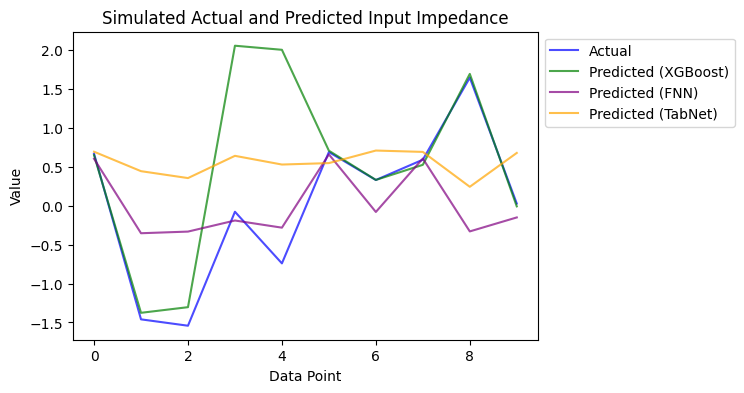

In [69]:
y_test_2 = np.mean(y_test_2.reshape(-1, batch_size), axis=1)
mse_xgb = mean_squared_error(y_test_2, y_pred_2_xgb)
mae_xgb = mean_absolute_error(y_test_2, y_pred_2_xgb)
r_squared_xgb = r2_score(y_test_2, y_pred_2_xgb)
mse_nn = mean_squared_error(y_test_2, y_pred_2_nn)
mae_nn = mean_absolute_error(y_test_2, y_pred_2_nn)
r_squared_nn = r2_score(y_test_2, y_pred_2_nn)
mse_tab = mean_squared_error(y_test_2, y_pred_2_tab)
mae_tab = mean_absolute_error(y_test_2, y_pred_2_tab)
r_squared_tab = r2_score(y_test_2, y_pred_2_tab)
print("Metrics for XGBoost Model:")
print(f"MSE: {mse_xgb:.4f}")
print(f"MAE: {mae_xgb:.4f}")
print(f"R-squared (R²): {r_squared_xgb:.4f}")
print("\nMetrics for FNN Model:")
print(f"MSE: {mse_nn:.4f}")
print(f"MAE: {mae_nn:.4f}")
print(f"R-squared (R²): {r_squared_nn:.4f}")
print("\nMetrics for TabNet Model:")
print(f"MSE: {mse_tab:.4f}")
print(f"MAE: {mae_tab:.4f}")
print(f"R-squared (R²): {r_squared_tab:.4f}")

colors = ['blue', 'green', 'purple', 'orange', 'red', 'cyan']

plt.figure(figsize=(6, 4))
plt.plot(range(len(y_test_2)), y_test_2, label='Actual', color=colors[0], alpha=0.7)
plt.plot(range(len(y_test_2)), y_pred_2_xgb, label='Predicted (XGBoost)', color=colors[1], alpha=0.7)
plt.plot(range(len(y_test_2)), y_pred_2_nn, label='Predicted (FNN)', color=colors[2], alpha=0.7)
plt.plot(range(len(y_test_2)), y_pred_2_tab, label='Predicted (TabNet)', color=colors[3], alpha=0.7)

plt.title('Simulated Actual and Predicted Input Impedance')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()